Please note that I've put # infront of the fit and predicts of the models and some other functions. The notebook has been created entirely in colab.google.com so some additional lines might not work in this jupyther. Regardless even if those cells are run the history of epochs and MSE would be lost so please first read the notebook and finally do the check with running all cells if you do the check.

In [0]:
%matplotlib inline

In [0]:
%tensorflow_version 2.x

In [53]:
import tensorflow
print(tensorflow.__version__)

2.1.0


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from datetime import datetime
import os

from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Reshape, Dot, Dropout
from tensorflow.keras.optimizers import Adam

%load_ext tensorboard

#from tensorboard import notebook

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Deep Neural Book Recommender

## Create and optimize a book recommender using deep neural network.

Author: Aleksandar Vladimirov

14/02/2020

Abstract

I’ve been interested in how you get suggestions for what to watch, listen and read. Netflix, Youtube, Spotify and well, Goodreads come to mind. And though I’m thinking of a Netflix subscription just out of interest how good can it get for me for real me and became addicted to Spotify and Movielens recommendation engines are quite interesting. This of course begs the question of course is how are you going to experience something new which is quite unlike yourself (and other with similar tastes people) if you’re constantly bombarded with stuff similar to those you’ve already tried. 

## Table of content:

1. Introduction
2. Load the data
3. Let's take a look at our data (EDA)
4. Prepare, train and optimize the model
5. Conclusion

##1. Introduction

This is my first time working with tensorflow and google.colab so it’s been quite interesting. I’m using colab because my laptop begs for retirement but I won’t let it go (probably how I’m going to be in 40/45 years time :D )

Regarding the recommenders there are more example of movie/song recommenders but too few for books, so I decided to go with a recommender for a book.

The dataset I'll be using has data for 10000 books and 53424 users.

## 2. Load the data

The data is pulled from the goodreads.com site and description of it can be found here:
https://www.kaggle.com/zygmunt/goodbooks-10k
Lucky for me there was a new cleaner version of the data and I’m using directly the links from the link provided in the Kaggle, but I will put it here as well.
https://github.com/zygmuntz/goodbooks-10k.


In [0]:
#So I'm going to load a few datasets and see what is relevant and what is not
books_df = pd.read_csv("https://github.com/zygmuntz/goodbooks-10k/raw/master/books.csv")
ratings_df = pd.read_csv("https://github.com/zygmuntz/goodbooks-10k/raw/master/ratings.csv")
#just in case to_read table
to_read_df = pd.read_csv("https://github.com/zygmuntz/goodbooks-10k/raw/master/to_read.csv")

In [56]:
#The usual sample to see what columns we have, and their naming.
ratings_df.sample()

,user_id,book_id,rating
2006560,27415,1234,4


In [57]:
#The same for books_df. It seems that here we have a lot of columns, but I'm going to leave it for now as all the data I need is in ratings_df.
books_df.sample(2)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
8651,8652,295169,295169,2919537,54,786814179,9.780787e+12,"William Nicholson, Peter Sís",2000.0,The Wind Singer,"The Wind Singer (Wind on Fire, #1)",eng,3.84,12654,14508,472,341,957,3647,5351,4212,https://images.gr-assets.com/books/1293635554m...,https://images.gr-assets.com/books/1293635554s...
1250,1251,6468666,6468666,6659237,39,1841497126,9.781841e+12,Kelley Armstrong,2010.0,The Reckoning,"The Reckoning (Darkest Powers, #3)",en-GB,4.21,92922,96809,3418,1256,3395,15949,29157,47052,https://images.gr-assets.com/books/1327154591m...,https://images.gr-assets.com/books/1327154591s...


##3 Let's take a look at our data (EDA)

So we need to check the data, like shape, data types, describe it to see anything which needs correcting (though this is cleaner dataset and should be ok). Checking just in case.

In [58]:
ratings_df.shape

(5976479, 3)

In [59]:
ratings_df.dtypes

user_id    int64
book_id    int64
rating     int64
dtype: object

In [60]:
ratings_df.describe()

,user_id,book_id,rating
count,5.976479e+06,5.976479e+06,5.976479e+06
mean,2.622446e+04,2.006477e+03,3.919866e+00
std,1.541323e+04,2.468499e+03,9.910868e-01
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.281300e+04,1.980000e+02,3.000000e+00
50%,2.593800e+04,8.850000e+02,4.000000e+00
75%,3.950900e+04,2.973000e+03,5.000000e+00
max,5.342400e+04,1.000000e+04,5.000000e+00


In [61]:
#Going to check if the ratings are as described.
ratings_df.rating.unique()

array([5, 4, 3, 2, 1])

In [62]:
#Now let's see the distribution of those ratings from 1 to 5.
ratings_df.groupby("rating")["user_id"].count()/ratings_df.shape[0] * 100

rating
1     2.078063
2     6.011182
3    22.938523
4    35.790605
5    33.181628
Name: user_id, dtype: float64

So the predominant ratings are high only around 8% are with low (1 or 2 as a rating). Let's check how this looks like visually.

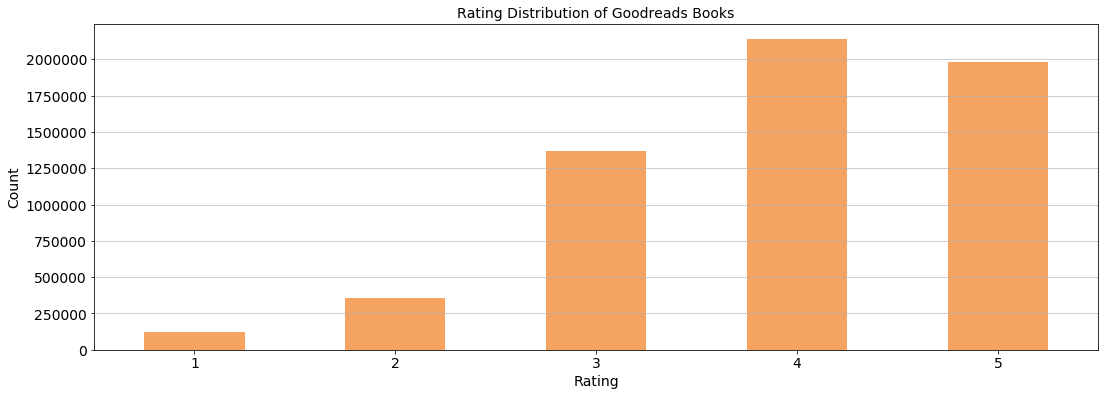

In [63]:
hist , bin_edges = np.histogram(ratings_df.rating)
bin_edges = np.round(bin_edges , 0)

plt.figure(figsize = [18,6])

plt.bar(bin_edges[:-1] , hist, width = 0.5, color = "sandybrown",)

plt.xlim(min(bin_edges) - 0.5 , max(bin_edges) + 0.5)

plt.grid(axis="y", alpha=0.75)
plt.xlabel("Rating" , fontsize=14)
plt.ylabel("Count" , fontsize=14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel("Count" , fontsize = 14)
plt.title("Rating Distribution of Goodreads Books" , fontsize = 14)
plt.show()

Almost 70% of the ratings are high (4 or 5). This seems logical since usually in order to rate a movie, song or a book you have to respectively watch/listen or read it. Since it might take days to read a book (comparatively more that the 1-2 hours for a movie or a few minutes for a song) it's normal to see only higher ratings for books.

Let's see what's the distribution of rating per user.

In [0]:
rat_pu = ratings_df.groupby("user_id")["rating"].count()

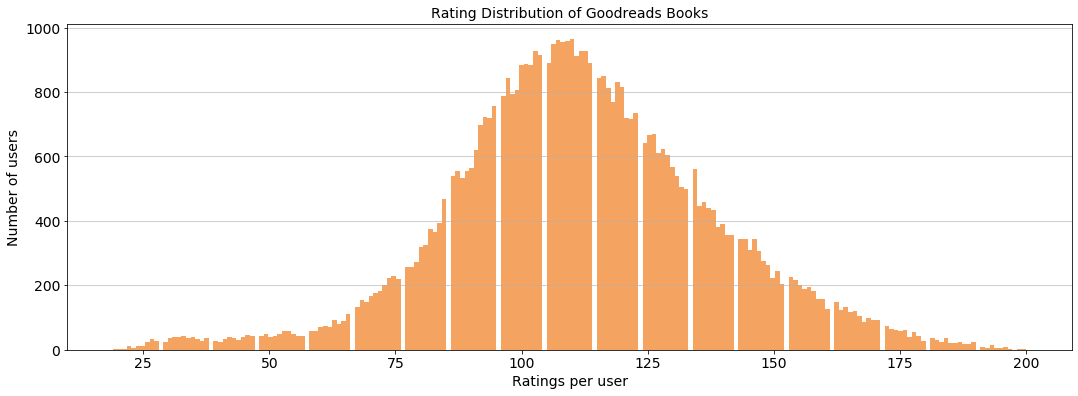

In [65]:
plt.figure(figsize = [18,6])
plt.hist(rat_pu, bins = 200, color = "sandybrown")

plt.grid(axis="y", alpha=0.75)
plt.xlabel("Ratings per user" , fontsize=14)
plt.ylabel("Number of users" , fontsize=14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel("Number of users" , fontsize = 14)
plt.title("Rating Distribution of Goodreads Books" , fontsize = 14)

plt.show()

Pretty normal distribution, since initially the users are asked to rate at least 20 books (to prevent the cold start) there are no users with less than 20 reviews.

In [0]:
#Since I don't need the df anymore let's delete it.
del rat_pu

In [0]:
rat_pm = ratings_df.groupby("book_id")["rating"].count()

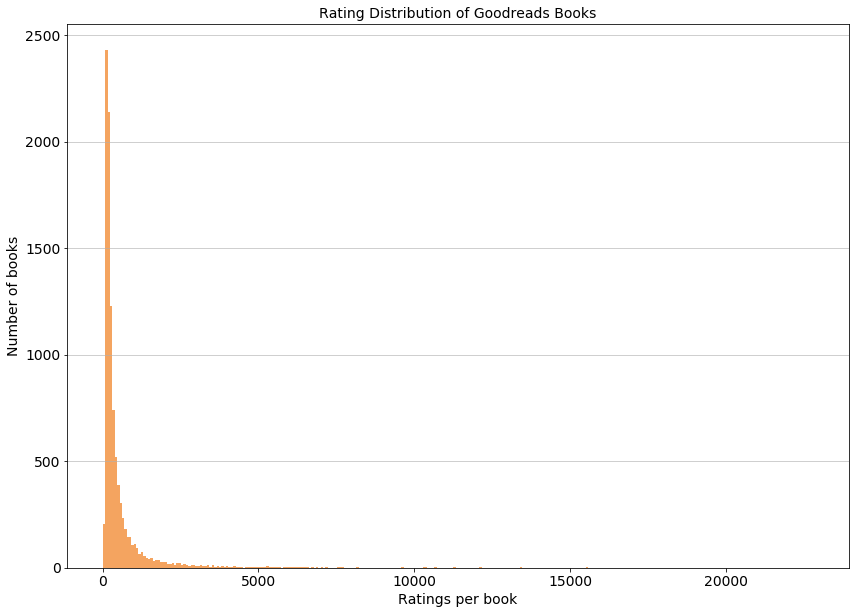

In [68]:
plt.figure(figsize = [14,10])
plt.hist(rat_pm, bins = 300, color = "sandybrown")

plt.grid(axis="y", alpha=0.75)
plt.xlabel("Ratings per book" , fontsize=14)
plt.ylabel("Number of books" , fontsize=14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel("Number of books" , fontsize = 14)
plt.title("Rating Distribution of Goodreads Books" , fontsize = 14)

plt.show()

We can see that the majority of the books don't have a lot of ratings.

In [69]:
#Since I'm curios to know which is the book with the most reviews :))
ratings_df.groupby("book_id")["rating"].count().max()

22806

In [70]:
rat_pm[ratings_df.groupby("book_id")["rating"].count() == 22806]

book_id
1    22806
Name: rating, dtype: int64

In [71]:
books_df.title[books_df["book_id"] == 1]

0    The Hunger Games (The Hunger Games, #1)
Name: title, dtype: object

In [0]:
#Since I don't need rat_pu anymore I'm going to delete it.
del rat_pm

##2. Deep Learninig Recommendation 

In [0]:
#So let's shuffle the rows and then split the dataset to train and test datasets.
ratings_df = ratings_df.sample(frac=1).reset_index(drop=True)

#Testing size can be 100 k (around 1.6% of the data)
n = 100000

#And create out test/train split.
test_df = ratings_df[:n]
train_df = ratings_df[n:]

In [0]:
#Now let's create user_id and book_id mapping:
user_id_m = {id:i for i, id in enumerate(train_df["user_id"].unique())}
book_id_m = {id: i for i, id in enumerate(train_df["book_id"].unique())}

In [0]:
#Apply this mapping to the train and test datasets.
train_df_m_u = train_df["user_id"].map(user_id_m)
train_df_m_b = train_df["book_id"].map(book_id_m)

test_df_m_u = test_df["user_id"].map(user_id_m)
test_df_m_b = test_df["book_id"].map(book_id_m)

In [76]:
#Set the lenght of users/books and just check what we did.
users = len(user_id_m)
books = len(book_id_m)
print(users)
print(books)

53424
10000


Since we will have two separate input layers, embeddings etc, seems more logical to use "Model" in stead of sequential, as I don't see any logic the input of users to go into the next layer (input of books). But we're gonna concatenate the vectors for those two. With "Model" we can tell from which layer the current layer should take it's input. So let's see this.

In [0]:
#Set the embedding size.
embedding_size = 10

#We should start with setting input layers
user_id_input = Input(shape = [1], name = "user")
book_id_input = Input(shape = [1], name = "book")

In [0]:
#Then we can proceed with user and book embeddings as shown below:
user_embedding = Embedding(input_dim = users,
                           output_dim = embedding_size,
                           input_length = 1, 
                           name = "user_embedding")(user_id_input)

In [0]:
book_embedding = Embedding(input_dim = books,
                           output_dim = embedding_size,
                           input_length = 1,
                           name = "book_embedding")(book_id_input)

In [0]:
#Then reshape the user and book vectors
user_vector = Reshape([embedding_size])(user_embedding)
book_vector = Reshape([embedding_size])(book_embedding)

In [0]:
#And concatenate those, so that we can feed it to dense layers
concatt = Concatenate()([user_vector, book_vector])

In [0]:
#Setting up the dense layers and the outpu
dense1 = Dense(128, activation = "relu")(concatt)
#dense2 = Dense(128)(dense1)
#dense3 = Dense(128)(dense2)
dense4 = Dense(256, activation = "relu")(dense1)
out = Dense(1)(dense4)

In [0]:
#Setting up two callbacks - one for the tensorboard and one for saving the model (model checkpoint)

log_dir="logs/profile/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback saving only the best model which can be loaded later eventually
cpt_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only = True, 
                                                 verbose=1)

In [85]:
lrnng_rate = 1e-3
epchs = 10
btch_size = 128

model = Model(inputs = [user_id_input, book_id_input], outputs = out)

model.compile(loss = "mse", optimizer = Adam(lrnng_rate))

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
book (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        534240      user[0][0]                       
__________________________________________________________________________________________________
book_embedding (Embedding)      (None, 1, 10)        100000      book[0][0]                       
______________________________________________________________________________________________

In [89]:
#model.fit([train_df_m_u, train_df_m_b],
#          train_df["rating"],
#          batch_size = btch_size, 
#          epochs = epchs,
#          validation_split = 0.1,
#          shuffle = True,
#          callbacks = [tensorboard_callback, cpt_callback])

Train on 5288831 samples, validate on 587648 samples
Epoch 1/10
5288448/5288831 [============================>.] - ETA: 0s - loss: 0.7727
Epoch 00001: val_loss improved from inf to 0.73097, saving model to training_1/cp.ckpt
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets
5288831/5288831 [==============================] - 345s 65us/sample - loss: 0.7727 - val_loss: 0.7310
Epoch 2/10
5288576/5288831 [============================>.] - ETA: 0s - loss: 0.7045
Epoch 00002: val_loss improved from 0.73097 to 0.70047, saving model to training_1/cp.ckpt
INFO:tensorflow:Assets written to: training_1/cp.ckpt/assets
5288831/5288831 [==============================] - 347s 66us/sample - loss: 0.7045 - val_loss: 0.7005
Epoch 3/10
5288320/5288831 [============================>.] - ETA: 0s - loss: 0.6697
Epoch 00003: val_loss improved from 0.70047 to 0.68680, saving model to training_1/cp.ckpt
INFO:tensorflow:

In [90]:
#I was pleasantly surprised when I saw there's the option to run tensorboard in google colab.... well not for long.
#Since I've tried several times to run it and every single time received an error below I'm just leaving it - I tried. ;(
#%tensorboard --logdir logs/profile/

<IPython.core.display.Javascript object>

In [91]:
#y_pred = model.predict([test_df_m_u, test_df_m_b])
#y_true = test_df["rating"].values

#mse = mean_squared_error(y_pred=y_pred, y_true=y_true)
#print("\n\nTesting Result With Keras Deep Learning: {:.4f} MSE".format(mse))



Testing Result With Keras Deep Learning: 0.6798 MSE


In [92]:
#Found alternative for the tensorboard so I'm going to work around this.
#https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_profiling_keras.ipynb#scrollTo=TZOf_K4L-Nkv
#!tar -zcvf logs.tar.gz logs/profile/

logs/profile/
logs/profile/20200214-032655/
logs/profile/20200214-032655/validation/
logs/profile/20200214-032655/validation/events.out.tfevents.1581651158.cb45734a9039.141.258307.v2
logs/profile/20200214-032655/train/
logs/profile/20200214-032655/train/events.out.tfevents.1581650818.cb45734a9039.profile-empty
logs/profile/20200214-032655/train/plugins/
logs/profile/20200214-032655/train/plugins/profile/
logs/profile/20200214-032655/train/plugins/profile/2020-02-14_03-26-58/
logs/profile/20200214-032655/train/plugins/profile/2020-02-14_03-26-58/local.trace
logs/profile/20200214-032655/train/events.out.tfevents.1581650815.cb45734a9039.141.278.v2


![title](img/1st_training.jpg)

Orange is train, blue is validation losses respectively. Really no point to run after epoch 7 because we start overfitting and our validation loss increases.

So below I'm going to make some minor modifications and train the model again. Not going to put the text above each code as this has been already mentioned in the first example. Might explore the option to put a function for the repetitive stuff, but for now I find it more easier for debugging/tracking purposes to have everything outlined.

In [0]:
dense1 = Dense(128, activation = "relu")(concatt)
#dense2 = Dropout(drpt_rate)(dense1)
dense3 = Dense(256, activation = "relu")(dense1)
#dense4 = Dropout(drpt_rate)(dense3)

out = Dense(1)(dense3)

In [0]:
log_dir="logs/profile/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback saving only the best model which can be loaded later eventually
cpt_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only = True, 
                                                 verbose=1)

In [95]:
#So let's change the learning rate and see what the impact of this will be.
lrnng_rate = 1e-4
epchs = 7
btch_size = 128

model = Model(inputs = [user_id_input, book_id_input], outputs = out)

model.compile(loss = "mse", optimizer = Adam(lrnng_rate))

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
book (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        534240      user[0][0]                       
__________________________________________________________________________________________________
book_embedding (Embedding)      (None, 1, 10)        100000      book[0][0]                       
____________________________________________________________________________________________

In [96]:
#model.fit([train_df_m_u, train_df_m_b],
#          train_df["rating"],
#          batch_size = btch_size,
#          epochs = epchs,
#          validation_split = 0.1,
#          shuffle = True,
#          callbacks = [tensorboard_callback, cpt_callback])

Train on 5288831 samples, validate on 587648 samples
Epoch 1/7
5288576/5288831 [============================>.] - ETA: 0s - loss: 0.6391
Epoch 00001: val_loss improved from inf to 0.68660, saving model to training_2/cp.ckpt
INFO:tensorflow:Assets written to: training_2/cp.ckpt/assets
5288831/5288831 [==============================] - 341s 64us/sample - loss: 0.6391 - val_loss: 0.6866
Epoch 2/7
5288576/5288831 [============================>.] - ETA: 0s - loss: 0.5850
Epoch 00002: val_loss did not improve from 0.68660
5288831/5288831 [==============================] - 349s 66us/sample - loss: 0.5850 - val_loss: 0.6902
Epoch 3/7
5288320/5288831 [============================>.] - ETA: 0s - loss: 0.5766
Epoch 00003: val_loss did not improve from 0.68660
5288831/5288831 [==============================] - 341s 64us/sample - loss: 0.5766 - val_loss: 0.6885
Epoch 4/7
5288576/5288831 [============================>.] - ETA: 0s - loss: 0.5716
Epoch 00004: val_loss did not improve from 0.68660
5288

KeyboardInterrupt: ignored

Stopeed it intentionally. Really no point in running more epochs as I can see that the results are not better and the validation loss increases or stays higher that the 1st training (and the lowest epoch for the current training achieve in epoch 1 of MSE 0.6866

In [0]:
# Skipping also this part
#!tar -zcvf logs.tar.gz logs/profile

logs/profile/
logs/profile/20200213-184316/
logs/profile/20200213-184316/validation/
logs/profile/20200213-184316/validation/events.out.tfevents.1581619694.14b4085c7157.140.1553580.v2
logs/profile/20200213-184316/train/
logs/profile/20200213-184316/train/events.out.tfevents.1581619417.14b4085c7157.profile-empty
logs/profile/20200213-184316/train/events.out.tfevents.1581619416.14b4085c7157.140.1295453.v2
logs/profile/20200213-184316/train/plugins/
logs/profile/20200213-184316/train/plugins/profile/
logs/profile/20200213-184316/train/plugins/profile/2020-02-13_18-43-37/
logs/profile/20200213-184316/train/plugins/profile/2020-02-13_18-43-37/local.trace
logs/profile/.ipynb_checkpoints/


In [97]:
#y_pred = model.predict([test_df_m_u, test_df_m_b])
#y_true = test_df["rating"].values

#mse = mean_squared_error(y_pred=y_pred, y_true=y_true)
#print("\n\nTesting Result With Keras Deep Learning: {:.4f} MSE".format(mse))



Testing Result With Keras Deep Learning: 0.6899 MSE


The MSE error on the test set is higher as expected after seeing the epochs.

In [0]:
#%tensorboard — logdir logs

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] {serve,dev} ...
tensorboard: error: invalid choice: '—' (choose from 'serve', 'dev')

Now I'm going to add new layer and see if the MSE will improve.

In [0]:
#Setting up the layers:

dense1 = Dense(64, activation = "relu")(concatt)
dense2 = Dense(128, activation = "relu")(dense1)
dense3 = Dense(256, activation = "relu")(dense2)
#dense4 = Dropout(drpt_rate)(dense3)

out = Dense(1)(dense3)

In [0]:
#Setting up the callbacks:

log_dir="logs/profile/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_path = "training_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback saving only the best model which can be loaded later eventually
cpt_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only = True, 
                                                 verbose=1)

In [101]:
lrnng_rate = 1e-3
epchs = 7
btch_size = 128

model = Model(inputs = [user_id_input, book_id_input], outputs = out)

model.compile(loss = "mse", optimizer = Adam(lrnng_rate))

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
book (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        534240      user[0][0]                       
__________________________________________________________________________________________________
book_embedding (Embedding)      (None, 1, 10)        100000      book[0][0]                       
____________________________________________________________________________________________

In [102]:
#model.fit([train_df_m_u, train_df_m_b],
#          train_df["rating"],
#          batch_size = btch_size, 
#          epochs = epchs,
#          validation_split = 0.1,
#          shuffle = True,
#          callbacks = [tensorboard_callback, cpt_callback])

Train on 5288831 samples, validate on 587648 samples
Epoch 1/7
5288192/5288831 [============================>.] - ETA: 0s - loss: 0.6150
Epoch 00001: val_loss improved from inf to 0.68166, saving model to training_3/cp.ckpt
INFO:tensorflow:Assets written to: training_3/cp.ckpt/assets
5288831/5288831 [==============================] - 352s 67us/sample - loss: 0.6150 - val_loss: 0.6817
Epoch 2/7
5288704/5288831 [============================>.] - ETA: 0s - loss: 0.5930
Epoch 00002: val_loss did not improve from 0.68166
5288831/5288831 [==============================] - 352s 67us/sample - loss: 0.5930 - val_loss: 0.6825
Epoch 3/7
5288576/5288831 [============================>.] - ETA: 0s - loss: 0.5856
Epoch 00003: val_loss did not improve from 0.68166
5288831/5288831 [==============================] - 345s 65us/sample - loss: 0.5856 - val_loss: 0.6819
Epoch 4/7
5288448/5288831 [============================>.] - ETA: 0s - loss: 0.5803
Epoch 00004: val_loss did not improve from 0.68166
5288

In [103]:
#y_pred = model.predict([test_df_m_u, test_df_m_b])
#y_true = test_df["rating"].values

#mse = mean_squared_error(y_pred=y_pred, y_true=y_true)
#print("\n\nTesting Result With Keras Deep Learning: {:.4f} MSE".format(mse))



Testing Result With Keras Deep Learning: 0.6873 MSE


In [104]:
#!tar -zcvf logs.tar.gz logs/profile

logs/profile/
logs/profile/.ipynb_checkpoints/
logs/profile/20200214-052130/
logs/profile/20200214-052130/validation/
logs/profile/20200214-052130/validation/events.out.tfevents.1581658217.cb45734a9039.141.4077805.v2
logs/profile/20200214-052130/train/
logs/profile/20200214-052130/train/events.out.tfevents.1581657865.cb45734a9039.141.3819707.v2
logs/profile/20200214-052130/train/events.out.tfevents.1581657866.cb45734a9039.profile-empty
logs/profile/20200214-052130/train/plugins/
logs/profile/20200214-052130/train/plugins/profile/
logs/profile/20200214-052130/train/plugins/profile/2020-02-14_05-24-26/
logs/profile/20200214-052130/train/plugins/profile/2020-02-14_05-24-26/local.trace


![title](img/3rd_training.jpg)

So more deepener network didn't improve the MSE metric. Let's decrease the learninig rate then.

In [0]:
dense1 = Dense(128, activation = "relu")(concatt)
#dense2 = Dropout(drpt_rate)(dense1)
dense3 = Dense(256, activation = "relu")(dense1)
#dense4 = Dropout(drpt_rate)(dense3)

out = Dense(1)(dense3)

In [0]:
log_dir="logs/profile/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_path = "training_4/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback saving only the best model which can be loaded later eventually
cpt_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only = True, 
                                                 verbose=1)

In [107]:
#So let's change the learning rate and see what the impact of this will be.
lrnng_rate = 1e-2
epchs = 7
btch_size = 128

model = Model(inputs = [user_id_input, book_id_input], outputs = out)

model.compile(loss = "mse", optimizer = Adam(lrnng_rate))

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
book (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        534240      user[0][0]                       
__________________________________________________________________________________________________
book_embedding (Embedding)      (None, 1, 10)        100000      book[0][0]                       
____________________________________________________________________________________________

In [108]:
#model.fit([train_df_m_u, train_df_m_b],
#          train_df["rating"],
#          batch_size = btch_size, 
#          epochs = epchs,
#          validation_split = 0.1,
#          shuffle = True,
#          callbacks = [tensorboard_callback, cpt_callback])

Train on 5288831 samples, validate on 587648 samples
Epoch 1/7
5288320/5288831 [============================>.] - ETA: 0s - loss: 0.6949
Epoch 00001: val_loss improved from inf to 0.69751, saving model to training_4/cp.ckpt
INFO:tensorflow:Assets written to: training_4/cp.ckpt/assets
5288831/5288831 [==============================] - 340s 64us/sample - loss: 0.6949 - val_loss: 0.6975
Epoch 2/7
5288320/5288831 [============================>.] - ETA: 0s - loss: 0.6573
Epoch 00002: val_loss improved from 0.69751 to 0.69724, saving model to training_4/cp.ckpt
INFO:tensorflow:Assets written to: training_4/cp.ckpt/assets
5288831/5288831 [==============================] - 344s 65us/sample - loss: 0.6574 - val_loss: 0.6972
Epoch 3/7
5288064/5288831 [============================>.] - ETA: 0s - loss: 0.6374
Epoch 00003: val_loss improved from 0.69724 to 0.68504, saving model to training_4/cp.ckpt
INFO:tensorflow:Assets written to: training_4/cp.ckpt/assets
5288831/5288831 [======================

In [110]:
#y_pred = model.predict([test_df_m_u, test_df_m_b])
#y_true = test_df["rating"].values

#mse = mean_squared_error(y_pred=y_pred, y_true=y_true)
#print("\n\nTesting Result With Keras Deep Learning: {:.4f} MSE".format(mse))



Testing Result With Keras Deep Learning: 0.6876 MSE


In [109]:
#For the last time I'm going to download the logs and view them on tensorboard
#!tar -zcvf logs.tar.gz logs/profile

logs/profile/
logs/profile/.ipynb_checkpoints/
logs/profile/20200214-062339/
logs/profile/20200214-062339/validation/
logs/profile/20200214-062339/validation/events.out.tfevents.1581661765.cb45734a9039.141.5883762.v2
logs/profile/20200214-062339/train/
logs/profile/20200214-062339/train/plugins/
logs/profile/20200214-062339/train/plugins/profile/
logs/profile/20200214-062339/train/plugins/profile/2020-02-14_06-23-47/
logs/profile/20200214-062339/train/plugins/profile/2020-02-14_06-23-47/local.trace
logs/profile/20200214-062339/train/events.out.tfevents.1581661427.cb45734a9039.profile-empty
logs/profile/20200214-062339/train/events.out.tfevents.1581661426.cb45734a9039.141.5625733.v2


![title](img/4th_training.jpg)

Best model checkpoints attached in the "Logs and Ckpts" folder together with this notebook.

#4. Conclusoin

It turns out that the deep learning optimization is a lot more harder than the simpler grid_search. Couldn't decrease the mse loss more than the initial training. Though I did try a few combinations(out of this notebook) before deciding on the initial one. Next steps would be to work with a smaller sample, overfit it a bit and then regularize it. Another thing which I think about is to oversample the instances with low ratings as those were a really small part of the whole dataset (around 8%).